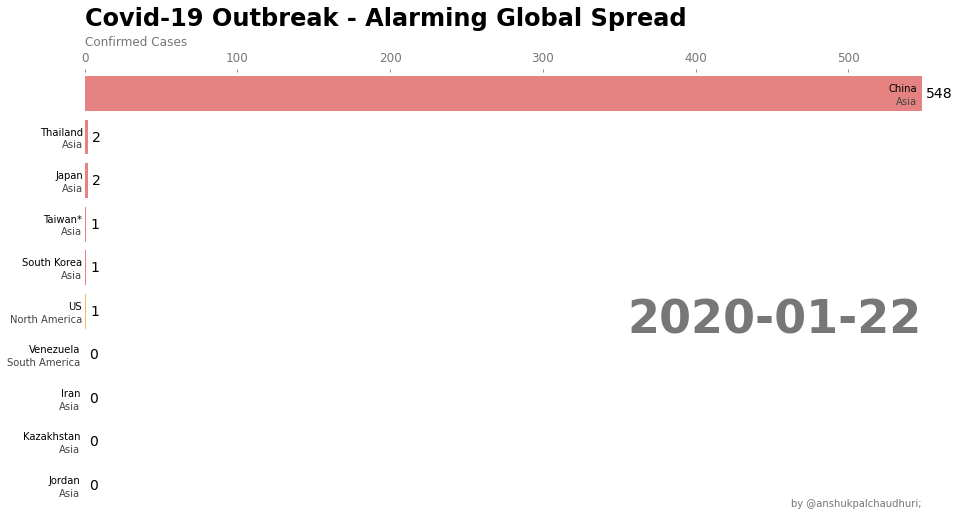

In [12]:
# imports
import pandas as pd
from urllib.parse import unquote
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.animation import PillowWriter    

class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(3000 / self.fps), loop=0)

def cleancountries(df):
   # changing the region name to cruis ship
  df.loc[df['Country'] == 'Diamond Princess', ['Country']] = 'Cruise Ship'
  return df

def getContinent(df):
    country_cont_map = pd.read_csv("mapping_countries.csv")
    df = pd.merge(df, country_cont_map, how='inner', on=['Country'])
    del df['Country']
    df.rename(columns={"Name": "Country"},inplace=True)
    return df
    
confirmed_df = pd.read_csv(unquote(unquote('https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv')))
del confirmed_df['Province/State']
confirmed_df.rename(columns={"Country/Region": "Country"},inplace=True)
confirmed_df = pd.melt(confirmed_df,id_vars=['Country','Lat','Long'], var_name='Day', value_name='ConfirmedCount')
del confirmed_df['Lat']
del confirmed_df['Long']

confirmed_df['Day'] = pd.to_datetime(confirmed_df['Day'])
confirmed_df['Day'] = confirmed_df['Day'].dt.date
confirmed_df = cleancountries(confirmed_df)
confirmed_df = getContinent(confirmed_df)

confirmed_df = confirmed_df.groupby(['Continent','Country','Day'])['ConfirmedCount'].sum().reset_index()

colors = dict(zip(
    ["Africa", "Europe", "Cruise", "Asia", "South America", "North America", "Oceania"],
    ["#adb0ff", "#ffb3ff", "#90d595", "#e48381", "#aafbff", "#f7bb5f", "#eafb50"]
))
group_lk = confirmed_df.set_index('Country')['Continent'].to_dict()

fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(current_date):
    dff = confirmed_df[confirmed_df['Day'].eq(current_date)].sort_values(by='ConfirmedCount', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['Country'], dff['ConfirmedCount'], color=[colors[group_lk[x]] for x in dff['Country']])
    dx = dff['ConfirmedCount'].max() / 200
    for i, (value, name) in enumerate(zip(dff['ConfirmedCount'], dff['Country'])):
        ax.text(value-dx, i,     name,           size=10, weight=200, ha='right', va='bottom')
        ax.text(value-dx, i-.25, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    ax.text(1, 0.4, current_date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Confirmed Cases ', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.grid(False)
    ax.set_axisbelow(True)
    ax.text(0, 1.15, 'Covid-19 Outbreak - Alarming Global Spread',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, 'by @anshukpalchaudhuri;', transform=ax.transAxes, color='#777777', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

array = confirmed_df['Day'].unique()
array = np.sort(array)
# print(array)

animator = animation.FuncAnimation(fig, draw_barchart, frames=array)
# HTML(animator.to_jshtml())
# animator.save('covid19-spread.mp4')
animator.save('covid19-spread.gif', writer=LoopingPillowWriter(fps=3))